In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import re
import math
from docx2python import docx2python

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
# plt.rcParams['figure.figsize'] = (12, 6)

# from google.colab import drive
# drive.mount('/content/drive')

data_dir = '../dataset/'

## Exploring Businesses

In [52]:
businesses_df = pd.read_csv(data_dir + 'business.csv')

# Dropping hours and attributes as their sub dictionaries are already added as features.
businesses_df.drop(['Unnamed: 0', 'hours', 'attributes'], axis=1, inplace=True)
businesses_df.head()

/geode2/home/u100/vimohan/Carbonate/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,9,26,27,32,38,44,59,80,93,104) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,attributes.Ambience.intimate,attributes.DietaryRestrictions.gluten-free,attributes.Ambience.touristy,attributes.HairSpecializesIn.perms,state,attributes.GoodForMeal.dinner,hours.Saturday,attributes.HairSpecializesIn.straightperms,attributes.DietaryRestrictions.kosher,attributes.RestaurantsReservations,attributes.BestNights.thursday,attributes.HasTV,attributes.HappyHour,attributes.Ambience.upscale,attributes.Ambience.divey,attributes.GoodForDancing,is_open,attributes.Music.background_music,attributes.BestNights,postal_code,attributes.RestaurantsPriceRange2,attributes.Corkage,attributes.Ambience,attributes.Music.dj,attributes.GoodForKids,attributes.AgesAllowed,attributes.DietaryRestrictions.soy-free,attributes.HairSpecializesIn.kids,hours.Friday,latitude,attributes.BusinessAcceptsBitcoin,attributes.RestaurantsCounterService,attributes.BestNights.wednesday,attributes.HairSpecializesIn.africanamerican,attributes.RestaurantsGoodForGroups,business_id,attributes.DriveThru,attributes.DietaryRestrictions.dairy-free,attributes.Caters,attributes.RestaurantsAttire,attributes.BestNights.tuesday,attributes.Ambience.trendy,attributes.BYOB,attributes.DietaryRestrictions.halal,attributes.Music.no_music,name,attributes.Music.karaoke,attributes.ByAppointmentOnly,attributes.BestNights.friday,attributes.Ambience.romantic,review_count,attributes.GoodForMeal.brunch,hours.Thursday,city,attributes.Music.video,attributes.OutdoorSeating,attributes.RestaurantsTableService,attributes.Ambience.classy,attributes.Open24Hours,attributes.GoodForMeal.lunch,attributes.BusinessParking,hours.Wednesday,longitude,attributes.HairSpecializesIn.extensions,attributes.GoodForMeal,attributes.NoiseLevel,attributes.BusinessParking.street,attributes.GoodForMeal.breakfast,categories,stars,attributes.DogsAllowed,hours.Monday,attributes.HairSpecializesIn.curly,attributes.BusinessParking.lot,attributes.BYOBCorkage,hours.Tuesday,attributes.GoodForMeal.latenight,attributes.WheelchairAccessible,attributes.DietaryRestrictions.vegan,attributes.BusinessParking.valet,address,attributes.BusinessParking.garage,attributes.BikeParking,attributes.RestaurantsTakeOut,attributes.CoatCheck,attributes.BusinessAcceptsCreditCards,attributes.Music.jukebox,attributes.Music,attributes.GoodForMeal.dessert,attributes.BestNights.saturday,attributes.DietaryRestrictions.vegetarian,attributes.Ambience.hipster,attributes.HairSpecializesIn.asian,attributes.HairSpecializesIn.coloring,attributes.AcceptsInsurance,attributes.Ambience.casual,hours.Sunday,attributes.WiFi,attributes.Music.live,attributes.HairSpecializesIn,attributes.RestaurantsDelivery,attributes.DietaryRestrictions,attributes.BestNights.sunday,attributes.Smoking,attributes.BestNights.monday,attributes.Alcohol,attributes.BusinessParking.validated
0,NaN,NaN,NaN,NaN,NC,NaN,11:0-20:0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,28031,3,NaN,NaN,NaN,False,NaN,NaN,NaN,11:0-20:0,35.462724,NaN,NaN,NaN,NaN,NaN,f9NumwFMBDn751xgFiRbNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The Range At Lake Norman,NaN,False,NaN,NaN,36,NaN,11:0-20:0,Cornelius,NaN,NaN,NaN,NaN,NaN,NaN,"'garage': False, 'street': False, 'validated':...",10:0-18:0,-80.852612,NaN,NaN,NaN,False,NaN,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...",3.5,NaN,10:0-18:0,NaN,True,NaN,11:0-20:0,NaN,NaN,NaN,False,10913 Bailey Rd,False,True,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13:0-18:0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,NaN,NaN,NaN,NaN,AZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,85258,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,33.569404,NaN,NaN,NaN,NaN,NaN,Yzvjg0SayhoZgCljUJRF9Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Carlos Santo, NMD",NaN,True,NaN,NaN,4,NaN,NaN,Scottsdale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-111.890264,NaN,NaN,NaN,NaN,NaN,"Health & Medical, Fitness & Instruction, Yoga,...",5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"8880 E Via Linda, Ste 107",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN

In [3]:
print('Total Businesses: ', len(businesses_df))
print('Open Businesses: ', len(businesses_df[businesses_df['is_open'] == 1]))

Total Businesses:  209393
Open Businesses:  168903


Filtering **Open** businesses only.

In [59]:
businesses_df = businesses_df[businesses_df['is_open'] == 1]

In [5]:
sorted(businesses_df['stars'].unique())

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

.5 incremental scale for business stars from 1 to 5.

In [6]:
businesses_df[['stars', 'business_id']].groupby(by='stars').count()

,business_id
stars,
1.0,5065
1.5,4961
2.0,10616
2.5,17068
3.0,21550
3.5,29288
4.0,31037
4.5,25072
5.0,24246


In [7]:
businesses_df['stars'].mean()

3.562805278769471

We can divide the businesses in 3 categories: low rating ( < 3), average/medium rating (3 - 4), high rating ( > 4)

In [8]:
businesses_df['rating_category'] = businesses_df['stars'].apply(lambda x: 'low' if x < 3 else ('medium' if x < 4 else 'high'))
businesses_df[['rating_category', 'business_id']].groupby(by='rating_category').count()

,business_id
rating_category,
high,80355
low,37710
medium,50838


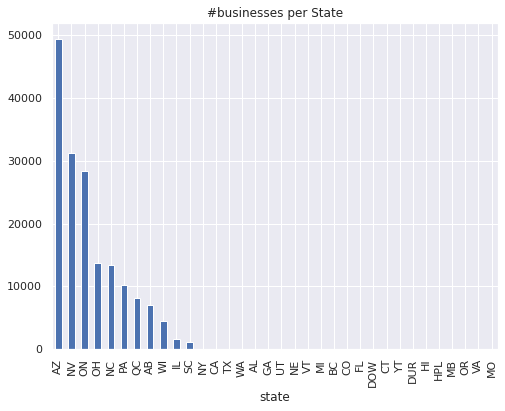

In [16]:
fig = businesses_df.groupby(by='state')['business_id'].count().sort_values(ascending=False).plot.bar(figsize=(8, 6), title='#businesses per State').get_figure()
fig.savefig('businesses per State')

In [11]:
businesses_df.groupby(by='state')['business_id'].count().sort_values(ascending=False).nlargest(7)

state
AZ    49415
NV    31180
ON    28433
OH    13762
NC    13433
PA    10206
QC     8215
Name: business_id, dtype: int64

We can filter out the businesses for top 5 or top 7 States only.

Or we can focus on top 3 and then filter out the cities from them (discuss)

<AxesSubplot:title={'center':'#businesses in Arizona State'}, xlabel='city'>

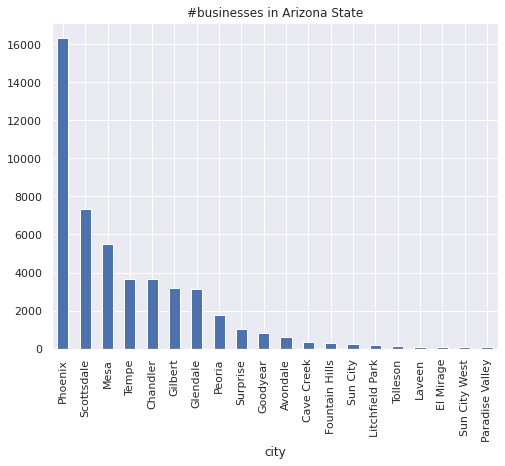

In [20]:
businesses_df[businesses_df['state'] == 'AZ'].groupby(by='city')['business_id'].count().sort_values(ascending=False).nlargest(20).plot.bar(figsize=(8, 6), 
                                                                                                                                           title='#businesses in Arizona State')

There are 1600 Categories.
There are lot of typos for example **Active Life**, **Active Lif** being 2 different Categories.

yelp maintains a blog for all it categories https://blog.yelp.com/2018/01/yelp_category_list
It was last updated on April 8, 2020.

From the blog it looks like there are 22 broad Categories and each of the above sub category can be classified into one of them.

In [60]:
# businesses with no categories
businesses_df[businesses_df['categories'].isna()]['business_id'].count()

502

In [53]:
doc_result = docx2python("Categories.docx")
categories_to_subcategories = {}
k = None
for i in doc_result.body[0][0][0]:
    if len(re.findall('\t', i)) == 0:
        k = ' '.join(re.findall(r'\w+', i))
        categories_to_subcategories[k] = [k]
    
    categories_to_subcategories[k].append(' '.join(re.findall(r'\w+', i)))
# categories_to_subcategories

In [54]:
subcategories_to_categories = {}
for k, v in categories_to_subcategories.items():
    for x in set(v):
        subcategories_to_categories.setdefault(x.lower(), []).append(k.lower())
# subcategories_to_categories

In [55]:
businesses_df['categories'] = businesses_df['categories'].apply(lambda x: re.sub(r"[^a-zA-Z0-9]" ," ", x) if type(x) is str else x)

In [56]:
# https://stackoverflow.com/questions/54481198/python-match-multiple-substrings-in-a-string
def clean_categories(string):
    if type(string) is str:
        categories = []
        for key, values in categories_to_subcategories.items():
            pattern = r'\b({})\b'.format('|'.join(map(re.escape, values)))
            matches = set(map(str.lower, re.findall(pattern, string, re.IGNORECASE)))
            categories.extend(list(filter(None, [x.lower() for x in values if x.lower() in matches])))
        return list(set(categories))
    else:
        return string

In [57]:
businesses_df['cleaned_categories'] = businesses_df['categories'].apply(clean_categories)
businesses_df['cleaned_categories'] = businesses_df['cleaned_categories'].apply(lambda x: x if type(x) is list else math.nan)
businesses_df['parent_categories'] = businesses_df['cleaned_categories'].apply(lambda x: list(set([subcategories_to_categories[k][0] for k in x])) if type(x) is list else x)
len(businesses_df['cleaned_categories'][businesses_df['cleaned_categories'].isna()])

524

Top 20 Subcategoris

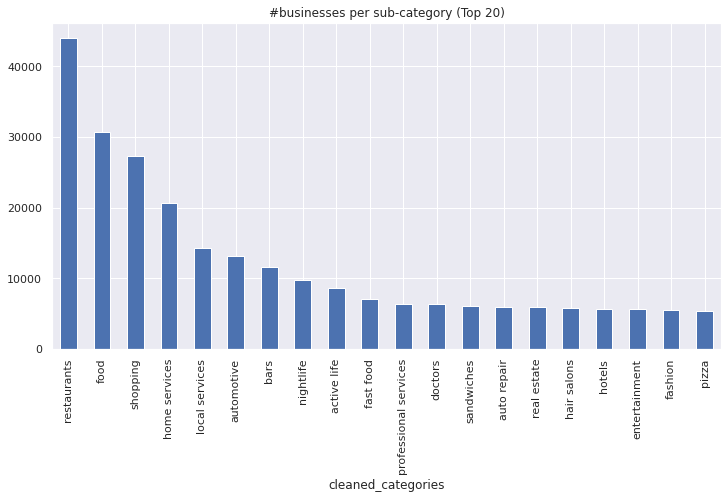

In [61]:
fig = businesses_df[['cleaned_categories', 'business_id']].explode('cleaned_categories').reset_index()[['cleaned_categories', 'business_id']].groupby(by='cleaned_categories')['business_id'].count().nlargest(20).sort_values(ascending=False).plot.bar(
    title='#businesses per sub-category (Top 20)', figsize=(12, 6)).get_figure()
fig.savefig('businesses per sub-category')

Count per Parent Category

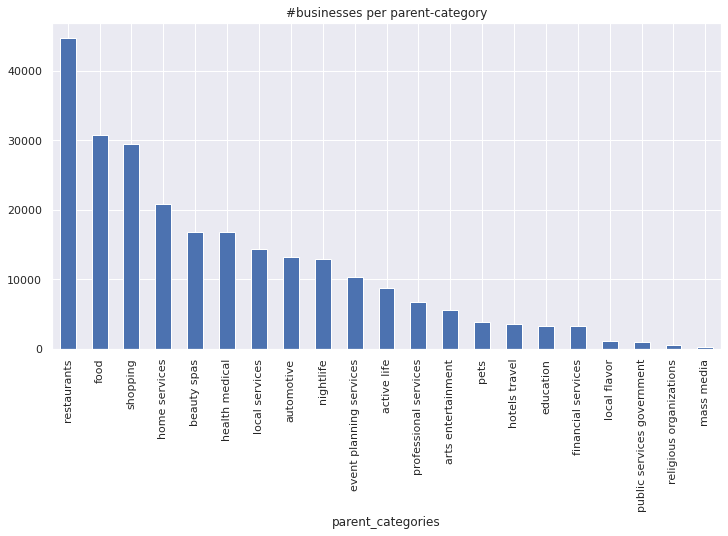

In [35]:
fig = businesses_df[['parent_categories', 'business_id']].explode('parent_categories').reset_index()[['parent_categories', 'business_id']].groupby(by='parent_categories')['business_id'].count().sort_values(ascending=False).plot.bar(
    title='#businesses per parent-category', figsize=(12, 6)).get_figure()
fig.savefig('businesses per parent-category')

In [36]:
del(businesses_df)

## Exploring Users

In [37]:
users_df = pd.read_csv(data_dir + 'user.csv')
users_df.drop(['Unnamed: 0'], axis=1, inplace=True)
users_df.head()

/geode2/home/u100/vimohan/Carbonate/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,average_stars,compliment_photos,compliment_note,elite,compliment_cool,compliment_hot,yelping_since,user_id,compliment_funny,cool,review_count,useful,name,compliment_writer,funny,compliment_cute,compliment_profile,compliment_more,compliment_plain,fans,compliment_list,friends
0,3.57,0,11,NaN,22,3,2007-07-06 03:27:11,ntlvfPzc8eglqvk92iDIAw,22,227,553,628,Rafael,10,225,0,1,2,15,14,1,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg..."
1,3.84,5,33,"2008,2009,2010,2011,2012,2013",63,36,2008-04-28 01:29:25,FOBRPlBHa3WPHFB5qYDlVg,63,400,564,790,Michelle,21,316,2,5,4,37,27,1,"ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug..."
2,3.44,1,3,2010,17,9,2008-08-28 23:40:05,zZUnPeh2hEp0WydbAZEOOg,17,103,60,151,Martin,4,125,1,0,6,7,5,0,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ..."
3,3.08,0,7,2009,7,2,2008-09-20 00:08:14,QaELAmRcDc5TfJEylaaP8g,7,84,206,233,John,2,160,0,0,1,14,6,0,"iog3Nyg1i4jeumiTVG_BSA, M92xWY2Vr9w0xoH8bPplfQ..."
4,4.37,31,22,"2009,2010,2011,2012,2014,2015,2016,2017,2018",31,8,2008-08-09 00:30:27,xvu8G900tezTzbbfqmTKvA,31,512,485,1265,Anne,19,400,1,2,9,28,78,1,"3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyLQ..."


In [38]:
users_df['year'] = pd.DatetimeIndex(pd.to_datetime(users_df['yelping_since'], format='%Y-%m-%d %H:%M:%S')).year

In [24]:
users_df[['year', 'user_id']].groupby(by='year').count()

,user_id
year,
2004,82
2005,1022
2006,6052
2007,17155
2008,34327
2009,68314
2010,115106
2011,185076
2012,203180


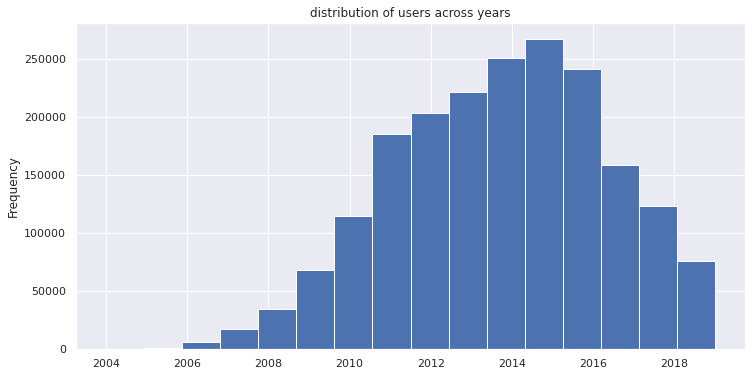

In [43]:
fig = users_df['year'].plot.hist(bins=len(users_df['year'].unique()), figsize=(12, 6), title='distribution of users across years').get_figure()
fig.savefig('distribution of users')

Filtering Users from 2010 - Present

<AxesSubplot:ylabel='Frequency'>

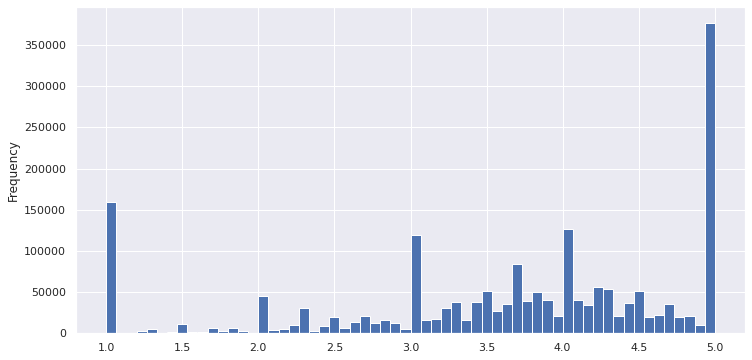

In [26]:
users_df['average_stars'].plot.hist(bins=60)

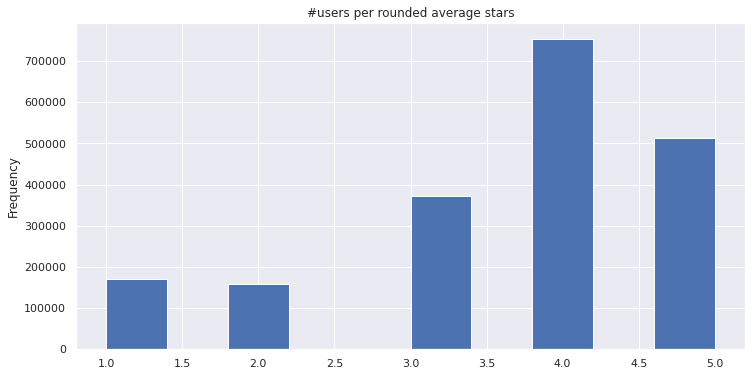

In [46]:
fig = users_df['average_stars'].apply(lambda x: round(x)).plot.hist(bins=10, figsize=(12, 6), title='#users per rounded average stars').get_figure()
fig.savefig('users per rounded average stars')

In [47]:
del(users_df)

## Exploring Reviews

In [48]:
reviews_df = pd.read_csv(data_dir + 'review.csv')
# reviews_df.drop(['cool', 'useful', 'funny'], axis=1, inplace=True)
for c in reviews_df.columns:
    reviews_df[c] = reviews_df[c].apply(lambda x: x[2:-1] if type(x) is str else x)
reviews_df['date'] = pd.to_datetime(pd.to_datetime(reviews_df['date'], format='%Y-%m-%d %H:%M:%S').dt.date, 
                                    format='%Y-%m-%d')
reviews_df.head()

,user_id,text,review_id,cool,stars,funny,useful,business_id,date
0,OwjRMXRC0KyPrIlcjaXeFQ,"As someone who has worked with many museums, I...",xQY8N_XvtGbearJ5X4QryQ,0,2.0,0,5,-MhfebM0QIsKt87iDN-FNw,2015-04-15
1,nIJD_7ZXHq-FX8byPMOkMQ,I am actually horrified this place is still in...,UmFMZ8PyXZTY2QcwzsfQYA,0,1.0,1,1,lbrU8StCq3yDfr-QMnGrmQ,2013-12-07
2,V34qejxNsCbcgD8C0HVk-Q,I love Deagan's. I do. I really do. The atmosp...,LG2ZaYiOgpr2DK_90pYjNw,0,5.0,0,1,HQl28KMwrEKHqhFrrDqVNQ,2015-12-05
3,ofKDkJKXSKZXu5xJNGiiBQ,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",i6g_oA9Yf9Y31qt0wibXpw,0,1.0,0,0,5JxlZaqCnk1MnbgRirs40Q,2011-05-27
4,UgMW8bLE0QMJDCkQ1Ax5Mg,"Oh happy day, finally have a Canes near my cas...",6TdNDKywdbjoTkizeMce8A,0,4.0,0,0,IS4cv902ykd8wj1TR0N3-A,2017-01-14


In [30]:
reviews_df.groupby(reviews_df["date"].dt.year)['review_id'].count()

date
2004         12
2005        875
2006       5030
2007      21130
2008      56996
2009     100760
2010     186752
2011     302523
2012     367367
2013     491678
2014     702060
2015     940603
2016    1094154
2017    1217292
2018    1318054
2019    1215836
Name: review_id, dtype: int64

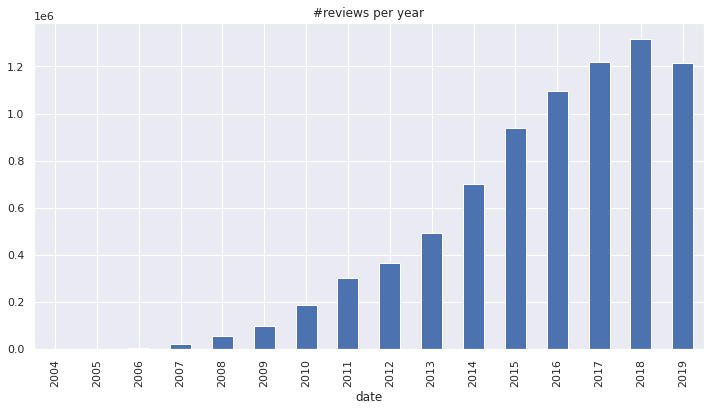

In [50]:
fig = reviews_df.groupby(reviews_df["date"].dt.year)['review_id'].count().plot(kind="bar", title='#reviews per year', figsize=(12, 6)).get_figure()
fig.savefig('reviews per year')

In [32]:
reviews_df['stars'].unique()

array([2., 1., 5., 4., 3.])

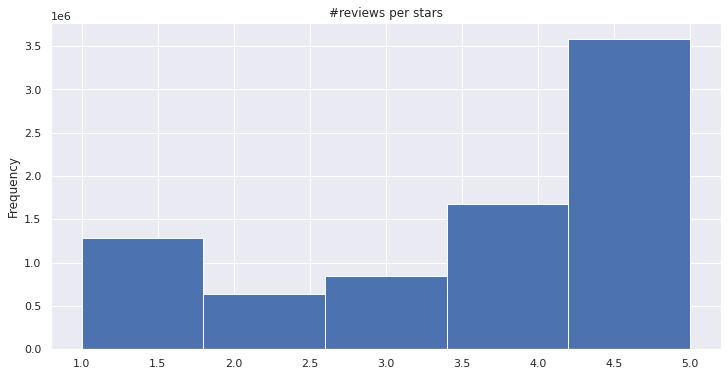

In [51]:
fig = reviews_df['stars'].plot.hist(bins=5, figsize=(12, 6), title='#reviews per stars').get_figure()
fig.savefig('reviews per stars')

In [34]:
reviews_df[['stars', 'review_id']].groupby('stars').count()

,review_id
stars,
1.0,1283897
2.0,635072
3.0,842289
4.0,1673404
5.0,3586460


In [35]:
reviews_df['stars'].mean()

3.7035746370644906

We can divide it into three categories like businesses (discuss)

In [36]:
reviews_df['rating_category'] = reviews_df['stars'].apply(lambda x: 'low' if x < 3 else ('medium' if x < 4 else 'high'))
reviews_df[['rating_category', 'business_id']].groupby(by='rating_category').count()

,business_id
rating_category,
high,5259864
low,1918969
medium,842289


In [37]:
res = reviews_df[['user_id', 'business_id', 'date','text']].groupby(by=['user_id', 'business_id', 'date'])['text'].count().sort_values(ascending=False)
res

user_id                 business_id             date      
YRcaNlwQ6XXPFDXWtuMGdA  epQzqMPbNjh5t0Td3T6TJA  2009-08-07    4
Pwmt1oPZ_jdnZlNZP0EwoA  oEqvC02g0ObZgQnvif9mUw  2014-07-17    4
2QvfdfB5TKQlDSJmzieC5g  t0aja59cII8eEVmC_x4sBw  2010-04-16    4
Z8D6JrC5SMogGi4AyBXGOA  kjY3355lQ-M2JHVwrey2qg  2014-04-21    3
0IGM3UHkx7wA50CGx2y2hw  kjY3355lQ-M2JHVwrey2qg  2019-10-09    3
                                                             ..
eVY-SWScYZmbQ11oGj1Vwg  N0CoaG3cBrTGm2ecLYSzqA  2019-01-06    1
                        RV657EzugeDNfHaRFZYa_A  2017-04-08    1
eVY3Cg0_iaM3mPwQKMJnqQ  VbRhikPI-Mmweau5WBv5CQ  2015-05-06    1
eVYDOW4tqeGrd2_pU3-xFA  t8DeC89bZFquyKoWi492xw  2018-09-07    1
---1lKK3aKOuomHnwAkAow  --9e1ONYQuAa-CB_Rrw7Tw  2008-11-11    1
Name: text, Length: 8019562, dtype: int64

Looks like there are multiple reviews on the same date from same user on the same business

In [38]:
reviews_df[(reviews_df['user_id'] == 'YRcaNlwQ6XXPFDXWtuMGdA') & 
           (reviews_df['business_id'] == 'epQzqMPbNjh5t0Td3T6TJA') &
          (reviews_df['date'] == '2009-08-07')]#[['text', 'stars']]

,user_id,text,review_id,cool,stars,funny,useful,business_id,date,rating_category
2416046,YRcaNlwQ6XXPFDXWtuMGdA,This is the location closest to my house. The...,o6ai4rXm79H0o73BMgOqfQ,0,1.0,0,0,epQzqMPbNjh5t0Td3T6TJA,2009-08-07,low
2435228,YRcaNlwQ6XXPFDXWtuMGdA,I drove the Mazda 3 hatch here. The car was p...,n4_SnHA4PhnVxztER2pdvQ,0,2.0,1,1,epQzqMPbNjh5t0Td3T6TJA,2009-08-07,low
2445851,YRcaNlwQ6XXPFDXWtuMGdA,I got into Zipcar through participating in the...,HTK2w35Hm_ZjY91C3Ve36A,1,4.0,0,3,epQzqMPbNjh5t0Td3T6TJA,2009-08-07,high
2449521,YRcaNlwQ6XXPFDXWtuMGdA,I've driven both the Matrix and Mini from this...,ThjiXoC6bABxmVm8CjGIWA,0,4.0,0,2,epQzqMPbNjh5t0Td3T6TJA,2009-08-07,high


looks weird

In [39]:
res = res[res > 1].index.values
len(res)

1537

I think we can ignore these

In [40]:
unzipped_res = list(zip(*res))
u, b, d = unzipped_res[0], unzipped_res[1], unzipped_res[2]
reviews_df = reviews_df[~((reviews_df['user_id'].isin(u)) & (reviews_df['business_id'].isin(b)) & (reviews_df['date'].isin(d)))]

Selecting Most recent review if multiple reviews are present from a user on the same business

In [41]:
idx = reviews_df.groupby(['user_id', 'business_id'])['date'].transform(max) == reviews_df['date']
reviews_df = reviews_df[idx]

In [42]:
# Check Again
# reviews_df['len_of_review'] = reviews_df['text'].apply(lambda x: len(x) if len(x) < 7000 else 7000)
# reviews_df[['len_of_review', 'stars']].plot.scatter(y='len_of_review', x='stars')

In [43]:
del(reviews_df)

## Exploring Tip

In [57]:
tips_df = pd.read_csv(data_dir + 'tip.csv')
tips_df.drop(['Unnamed: 0'], axis=1, inplace=True)
# for c in tips_df.columns:
#     tips_df[c] = tips_df[c].apply(lambda x: x[2:-1] if type(x) is str else x)
tips_df['date'] = pd.to_datetime(pd.to_datetime(tips_df['date'], format='%Y-%m-%d %H:%M:%S').dt.date, format='%Y-%m-%d')
tips_df.head()

,text,business_id,compliment_count,date,user_id
0,Here for a quick mtg,UYX5zL_Xj9WEc_Wp-FrqHw,0,2013-11-26,hf27xTME3EiCp6NL6VtWZQ
1,Cucumber strawberry refresher,Ch3HkwQYv1YKw_FO06vBWA,0,2014-06-15,uEvusDwoSymbJJ0auR3muQ
2,Very nice good service good food,rDoT-MgxGRiYqCmi0bG10g,0,2016-07-18,AY-laIws3S7YXNl_f_D6rQ
3,t's a small place. The staff is friendly,OHXnDV01gLokiX1ELaQufA,0,2014-06-06,Ue_7yUlkEbX4AhnYdUfL7g
4,"8 sandwiches, $24 total...what a bargain!!! An...",GMrwDXRlAZU2zj5nH6l4vQ,0,2011-04-08,LltbT_fUMqZ-ZJP-vJ84IQ


In [58]:
res = tips_df[['user_id', 'business_id', 'date','text']].groupby(by=['user_id', 'business_id', 'date'])['text'].count().sort_values(ascending=False)
res

user_id                 business_id             date      
72jwwqkbKvNc17wZIh4xqQ  VyjyHoBg3KC5BSFRlD0ZPQ  2013-05-17    19
v15qziW5NRbveksIoiDnqQ  Xb9gBMPCrgZ2ylESj82AqQ  2019-04-22    19
mkbx55W8B8aPLgDqex7qgg  etid3CozFvEOFcvDwHXsDw  2016-06-13    16
BUP6Izyj6B6V4DPnIajl2g  STsW9ALww7yeVNcRxXEmXQ  2013-10-18    14
o_dPk6REa-SPz0RD4J04Zw  XZbuPXdyA0ZtTu3AzqtQhg  2012-01-31    14
                                                              ..
-pJ7LCuCqhvzXJLTDSYYvQ  1lReBAd4iLe0rBLKiurw7Q  2010-11-25     0
LIj_X_4luQAWf3i10Gx1OA  0WI53UcYIJLPagGNSxnqJg  2012-06-16     0
GJJPGC3m5EGJHRDYW5HyZw  _J-nDE8uzOs4dW7FOVN54A  2018-06-22     0
                        Wf2IX3BtWSyeUKnoRX2dew  2019-05-16     0
xLoLwTzlTQ1Qj64prPoLIw  QpCYSH83E5qT9Vss28Odug  2019-05-26     0
Name: text, Length: 1291757, dtype: int64

In [59]:
tips_df[(tips_df['user_id'] == 'v15qziW5NRbveksIoiDnqQ') & 
           (tips_df['business_id'] == 'Xb9gBMPCrgZ2ylESj82AqQ') &
          (tips_df['date'] == '2019-04-22')]

,text,business_id,compliment_count,date,user_id
437277,First level fire extinguisher next to ice mach...,Xb9gBMPCrgZ2ylESj82AqQ,0,2019-04-22,v15qziW5NRbveksIoiDnqQ
441624,Free wifi,Xb9gBMPCrgZ2ylESj82AqQ,0,2019-04-22,v15qziW5NRbveksIoiDnqQ
446829,ire extinguisher next to pool and stairs and d...,Xb9gBMPCrgZ2ylESj82AqQ,0,2019-04-22,v15qziW5NRbveksIoiDnqQ
476238,lovely breakfast area under the stairs that a...,Xb9gBMPCrgZ2ylESj82AqQ,0,2019-04-22,v15qziW5NRbveksIoiDnqQ
494552,Hear the train at 3:05 AM,Xb9gBMPCrgZ2ylESj82AqQ,0,2019-04-22,v15qziW5NRbveksIoiDnqQ
497216,"Pool closed 4/21/19, then reopened with song p...",Xb9gBMPCrgZ2ylESj82AqQ,0,2019-04-22,v15qziW5NRbveksIoiDnqQ
519547,Fire extinguisher second level next to smoking...,Xb9gBMPCrgZ2ylESj82AqQ,0,2019-04-22,v15qziW5NRbveksIoiDnqQ
527456,They have pool towels next to the pool jets,Xb9gBMPCrgZ2ylESj82AqQ,0,2019-04-22,v15qziW5NRbveksIoiDnqQ
540435,"Fire extinguisher I asked machine, second level",Xb9gBMPCrgZ2ylESj82AqQ,0,2019-04-22,v15qziW5NRbveksIoiDnqQ
545988,Second level fire extinguisher next to designa...,Xb9gBMPCrgZ2ylESj82AqQ,0,2019-04-22,v15qziW5NRbveksIoiDnqQ


In [60]:
res = res[res > 1].index.values
len(res)

25154

In [61]:
unzipped_res = list(zip(*res))
u, b, d = unzipped_res[0], unzipped_res[1], unzipped_res[2]
tips_df = tips_df[~((tips_df['user_id'].isin(u)) & (tips_df['business_id'].isin(b)) & (tips_df['date'].isin(d)))]

In [62]:
tips_df[['user_id', 'business_id', 'text']].groupby(by=['user_id', 'business_id'])['text'].count().sort_values(ascending=False)

user_id                 business_id           
wxeTtPILiMl1L-yBB-D2HA  LBPl8N3ytjObk9-8NTfjVQ    104
jnLX1hU69HxLvQQ76Hfvvg  ZwmHWcscwVcWkhZJoxbvUQ     71
ztKdCT5La4wX8pOPutJBJQ  dA-8GCVKxUuyA8IdhQQp6w     62
i7NpX00x1o4HohNKlYl8YQ  55hXQybFQruQgWoEYl9cvQ     60
u0Tsdqtjq--k5RV1mq1hrg  ccGIAOl08zHt2lcn_UxPfw     55
                                                 ... 
pQ7cqiX9Ocs9Rk9yBDguRQ  uuaH1UNcqcV-alT6nh42WA      0
cUm-VQnFLSh93r1j8eowXQ  ffjnm1Es9fuPF1dnWEcWkA      0
GJJPGC3m5EGJHRDYW5HyZw  Wf2IX3BtWSyeUKnoRX2dew      0
                        _J-nDE8uzOs4dW7FOVN54A      0
xLoLwTzlTQ1Qj64prPoLIw  QpCYSH83E5qT9Vss28Odug      0
Name: text, Length: 983192, dtype: int64

Selecting Most recent tip if multiple tips are present from a user on the same business

In [63]:
idx = tips_df.groupby(['user_id', 'business_id'])['date'].transform(max) == tips_df['date']
print(len(tips_df), len(idx))
tips_df = tips_df[idx]

1090508 1090508


In [64]:
idx.sum(), len(idx)

(983192, 1090508)

In [65]:
# tips_df.to_csv('tips_cleaned.csv', index=False)

In [66]:
# tips_df.drop(['compliment_count', 'date'], axis = 1, inplace=True)
# tips_df.columns

In [67]:
# tips_df['compliment_count'].nlargest(20)

In [68]:
# reviews_df.merge(tips_df, on=['user_id', 'business_id'])

In [69]:
# businesses_df = pd.read_csv(data_dir + 'yelp_academic_dataset_business.csv')
# businesses_df.columns

In [70]:
del(tips_df)